### Finalizing the Graph

For this step we will do three things:

1.) Salt the network

2.) Add a time field, based on the length, and the road type

3.) Modify this time field base on the IRI

Import the usual suspects

In [1]:
import os, sys
import pandas as pd
import geopandas as gpd
import networkx as nx
from shapely.geometry import Point, MultiPoint
from shapely.wkt import loads
from scipy import spatial
from functools import partial
import pyproj
from shapely.ops import transform
sys.path.append(r'C:\Users\charl\Documents\GitHub\GOST_PublicGoods\GOSTNets\GOSTNets')
import GOSTnet as gn

networkx version: 2.3 
osmnx version: 0.9 


Import our Graph with IRI information attached. This graph already only has one subgraph.

In [2]:
pth = r'C:\Users\charl\Documents\GOST\SierraLeone\RoadNet'
G = nx.read_gpickle(os.path.join(pth, 'IRI_adj.pickle'))

Here we salt the network every 2km

In [3]:
G_salted = gn.salt_long_lines(G, 
                              source = 'epsg:4326', 
                              target = 'epsg:3857',
                              thresh = 2000,
                              factor = 1000,
                              attr_list = ['infra_type','osm_id','Type','iri'])

Identified 4750 unique edge(s) longer than 2000. 
Beginning new node creation...
22942 new edges added and 9500 removed to bring total edges to 153059
6721 new nodes added to bring total nodes to 66127


Reset the unique edge id

In [4]:
q = 0
for u, v, data in G.edges(data = True):
    data['unique_id'] = q
    q+=1

Next, we convert the network to time, supplying a speed in km/h for each road type

In [5]:
edge_gdf = gn.edge_gdf_from_graph(G_salted)

In [6]:
edge_gdf.infra_type.value_counts()

unclassified      50830
residential       42680
track             32206
tertiary           9540
secondary          5736
primary            5462
trunk              3506
service            2949
primary_link         74
secondary_link       32
trunk_link           26
tertiary_link        18
Name: infra_type, dtype: int64

Define a speed dictionary with a value for every unique road type in the above list

In [7]:
speeds = {'residential':20,
            'unclassified':15,
            'track':15,
            'tertiary':30,
            'secondary':40,
            'primary':50,
            'trunk':50,
            'service':15,
            'road':15,
            'primary_link':45,
            'tertiary_link':25,
            'secondary_link':35,
            'trunk_link':45}

In [8]:
G_salted_time = gn.convert_network_to_time(G_salted,
                                      distance_tag = 'length',
                                      graph_type = 'drive',
                                      road_col = 'infra_type',
                                      speed_dict = speeds,
                                      factor = 1000
                                     )

Next, we modify the time taken to cross the edge based on the IRI. 
Here, I am setting up an equation whereby - 
- For iri values of less than 5, the adj value is 100
- for iri values of more than 16, the adj value is the minimum
- for values in between, the adj value is a straight line interpolation between 100 and the minimum value

In [9]:
def AdjustTime(iri, min_iri = 5, max_iri = 16, min_adj = 50):
    if iri < min_iri:
        adj = 100
    elif iri > max_iri:
        adj = min_adj
    else:
        adj = ((-((100 - min_adj) / (max_iri - min_iri)) * iri) + (((100 - min_adj) / (max_iri - min_iri) * max_iri))) + min_adj
    return adj / 100

We can see this works by throwing in a few values:

In [10]:
print(AdjustTime(iri = 20))
print(AdjustTime(iri = 16))
print(AdjustTime(iri = 8))
print(AdjustTime(iri = 5))
print(AdjustTime(iri = 3))

0.5
0.5
0.8636363636363638
1.0
1.0


... and we can graph this as so

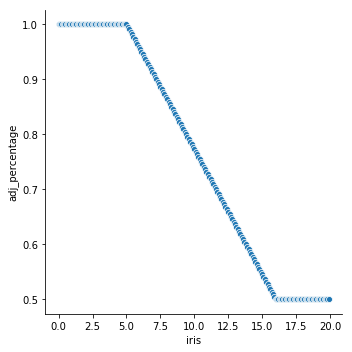

In [11]:
import numpy as np
import seaborn as sns

iris = list(np.arange(0, 20, step = 0.1))

adj_values = [AdjustTime(x) for x in iris]

df = pd.DataFrame({'iris': iris, 'adj_percentage':adj_values})

sns.relplot(x="iris", y="adj_percentage", data=df)

We apply this to our graph. If we assume we travel 50% slower on an iri = 16 road, our travel time will double (the inverse of the function plotted above). Hence:

In [12]:
for u, v, data in G_salted_time.edges(data = True):
    data['time_adj_factor'] = 1 / AdjustTime(data['iri'])
    data['time_adj'] = data['time'] * data['time_adj_factor']

Finally, before saving down, we reset all node IDs to integers to aid the grpahtool step

In [13]:
G_salted_time = nx.convert_node_labels_to_integers(G_salted_time)

Save down

In [14]:
gn.save(G_salted_time, 'final_G', pth, , nodes = False,  edges = False)